In [60]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(32)
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, fbeta_score, recall_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, make_scorer, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score, fbeta_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Diabetes dataset - final modeling

**Warning!**  

This code runs for a while, especially SHAP (that's around 3h)

In [61]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [62]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

Below are all functions used in our pipeline and scoring to evaluate the model (everything was described in the 2 milestone)

In [63]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [64]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [65]:
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [66]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95)),
    ('model', LogisticRegression())
])

In [67]:
def specificity_score(cm):
    tn, fp, fn, tp = cm.ravel() 
    return tn / (tn + fp)

In [68]:
def pipeline_fit(model):
    pipeline.set_params(model=model)
    pipeline.fit(X_train, y_train)

In [69]:
def scores_model(model, threshold=0.5):
    pipeline_fit(model)
    
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    y_train_scores = pipeline.predict_proba(X_train)[:, 1]
    y_test_scores = pipeline.predict_proba(X_test)[:, 1] 

    y_train_pred = (y_train_scores >= threshold).astype(int)
    y_test_pred = (y_test_scores >= threshold).astype(int)

    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  
    test_pr_auc = auc(recall_test, precision_test)  
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_prec = accuracy_score(y_train, y_train_pred)
    test_prec = accuracy_score(y_test, y_test_pred)
    cfm_train = confusion_matrix(y_train, y_train_pred)
    cfm = confusion_matrix(y_test, y_test_pred)
    train_f2 = fbeta_score(y_train, y_train_pred, beta=2)
    test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
    train_specificity = specificity_score(cfm_train)
    test_specificity = specificity_score(cfm)
    
    print("\nModel Performance:")
    print(f"Training Recall Score: {train_recall:.4f}")
    print(f"Test Recall Score: {test_recall:.4f}")
    print(f"Training F2 Score: {train_f2:.4f}")
    print(f"Test F2 Score: {test_f2:.4f}")
    print(f"Training Specificity Score: {train_specificity:.4f}")
    print(f"Test Specificity Score: {test_specificity:.4f}")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training Accuracy Score: {train_prec:.4f}")
    print(f"Test Accuracy Score: {test_prec:.4f}")
    print("Test Confusion Matrix:\n", cfm)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc, train_recall, test_recall, train_f2, test_f2, train_prec, test_prec, train_specificity, test_specificity)

We decided to continue with gboost since it seemed to be the most promising model.  
We are using HistGradientBoostingClassifier since it supports class weights which is expecially important with our unbalanced data.

Basic model


Model Performance:
Training Recall Score: 0.9342
Test Recall Score: 0.9261
Training F2 Score: 0.7712
Test F2 Score: 0.7686
Training Specificity Score: 0.8957
Test Specificity Score: 0.8979
Training ROC-AUC: 0.9150
Test ROC-AUC: 0.9120
Training PR-AUC: 0.8857
Test PR-AUC: 0.8862
Training Accuracy Score: 0.8990
Test Accuracy Score: 0.9003
Test Confusion Matrix:
 [[17254  1961]
 [  132  1653]]


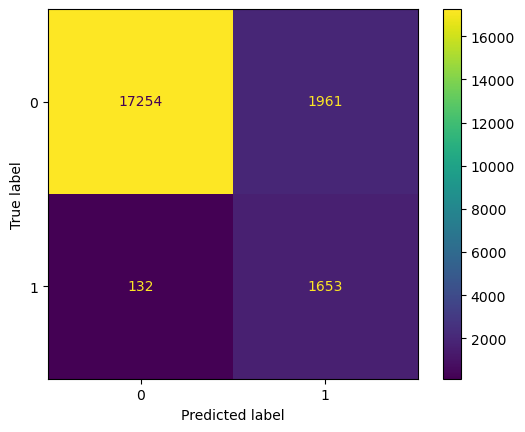

In [70]:
gboost0 = HistGradientBoostingClassifier(learning_rate=0.01, class_weight='balanced', random_state=32)
g0 = scores_model(gboost0)
gboost = HistGradientBoostingClassifier(random_state=32)

First randomized search

Best parameters: {'min_samples_leaf': 7, 'max_leaf_nodes': 10, 'max_iter': 300, 'max_features': 0.8, 'max_depth': 8, 'early_stopping': False}

Best model scores:

Model Performance:
Training Recall Score: 0.9304
Test Recall Score: 0.9345
Training F2 Score: 0.7565
Test F2 Score: 0.7584
Training Specificity Score: 0.8867
Test Specificity Score: 0.8861
Training ROC-AUC: 0.9086
Test ROC-AUC: 0.9103
Training PR-AUC: 0.8824
Test PR-AUC: 0.8895
Training Accuracy Score: 0.8904
Test Accuracy Score: 0.8902
Test Confusion Matrix:
 [[17026  2189]
 [  117  1668]]


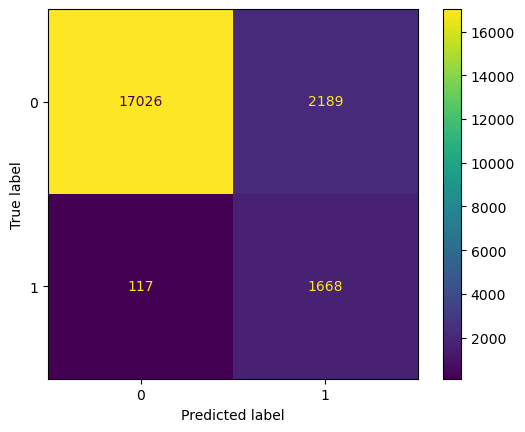

In [71]:
param_dist = {"max_depth" : range(2, 20),
              "max_features" : np.arange(0.1, 1.1, 0.1),
              "min_samples_leaf" : range(2, 20),
              "max_iter": [100, 200, 300],
              "max_leaf_nodes": [10, 20, 30],
              "early_stopping": [False, True]}

scorer = make_scorer(fbeta_score)

random_search_boost = RandomizedSearchCV(estimator=gboost0, param_distributions=param_dist, n_iter=50,
                                   cv=5, scoring=scorer, random_state=32)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

gboost2 = random_search_boost.best_estimator_

print("\nBest model scores:")
g2 = scores_model(gboost2)

Trying different scorings and refits to see which metrics work the best for our model.

Best parameters: {'min_samples_leaf': 13, 'max_leaf_nodes': 31, 'max_iter': 200, 'max_features': 0.2, 'max_depth': 5, 'learning_rate': 0.1, 'l2_regularization': 0.1, 'early_stopping': True, 'class_weight': {0: 1, 1: 5}}

Best model scores:

Model Performance:
Training Recall Score: 0.8550
Test Recall Score: 0.8359
Training F2 Score: 0.8166
Test F2 Score: 0.7999
Training Specificity Score: 0.9647
Test Specificity Score: 0.9639
Training ROC-AUC: 0.9098
Test ROC-AUC: 0.8999
Training PR-AUC: 0.9053
Test PR-AUC: 0.8940
Training Accuracy Score: 0.9554
Test Accuracy Score: 0.9530
Test Confusion Matrix:
 [[18521   694]
 [  293  1492]]


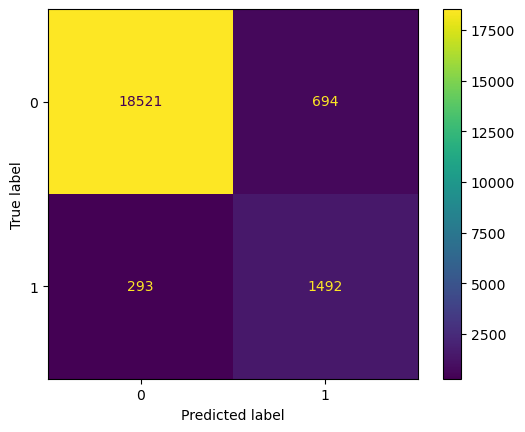

In [72]:
param_dist = {
    'max_depth': range(2, 20),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [31, 50, 100, 200],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorer = make_scorer(fbeta_score, beta=2)

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50, 
    cv=5,
    scoring=scorer, 
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Best parameters: {'min_samples_leaf': 14, 'max_leaf_nodes': 31, 'max_iter': 500, 'max_features': 0.9, 'max_depth': 15, 'learning_rate': 0.01, 'l2_regularization': 0.1, 'early_stopping': True, 'class_weight': {0: 1, 1: 5}}

Best model scores:

Model Performance:
Training Recall Score: 0.8629
Test Recall Score: 0.8420
Training F2 Score: 0.8186
Test F2 Score: 0.7982
Training Specificity Score: 0.9622
Test Specificity Score: 0.9598
Training ROC-AUC: 0.9125
Test ROC-AUC: 0.9009
Training PR-AUC: 0.9098
Test PR-AUC: 0.8936
Training Accuracy Score: 0.9537
Test Accuracy Score: 0.9498
Test Confusion Matrix:
 [[18443   772]
 [  282  1503]]


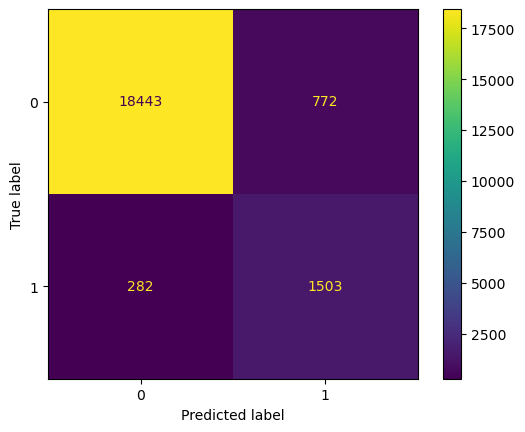

In [73]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,31, 50, 100, 200,300],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    'recall': make_scorer(recall_score)
}

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f2_score',  
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Best parameters: {'min_samples_leaf': 4, 'max_leaf_nodes': 2, 'max_iter': 400, 'max_features': 0.6, 'max_depth': 15, 'learning_rate': 0.05, 'l2_regularization': 0.1, 'early_stopping': True, 'class_weight': {0: 1, 1: 20}}

Best model scores:

Model Performance:
Training Recall Score: 0.9733
Test Recall Score: 0.9725
Training F2 Score: 0.7001
Test F2 Score: 0.6992
Training Specificity Score: 0.8163
Test Specificity Score: 0.8159
Training ROC-AUC: 0.8948
Test ROC-AUC: 0.8942
Training PR-AUC: 0.8768
Test PR-AUC: 0.8859
Training Accuracy Score: 0.8296
Test Accuracy Score: 0.8292
Test Confusion Matrix:
 [[15677  3538]
 [   49  1736]]


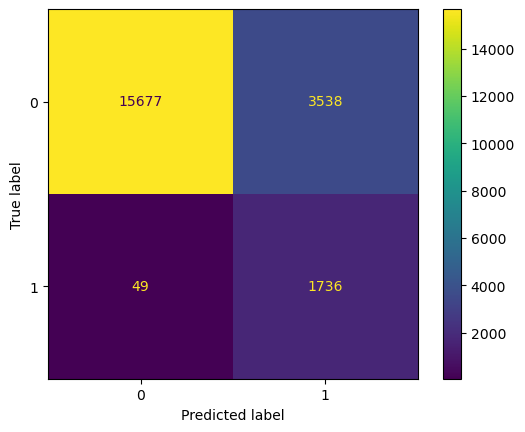

In [74]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,31, 50, 100, 200,300],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    'recall': make_scorer(recall_score)
}

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='recall',  
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Best parameters: {'min_samples_leaf': 12, 'max_leaf_nodes': 2, 'max_iter': 500, 'max_features': 0.8, 'max_depth': 11, 'learning_rate': 0.2, 'l2_regularization': 0, 'early_stopping': False, 'class_weight': {0: 1, 1: 20}}

Best model scores:

Model Performance:
Training Recall Score: 0.9702
Test Recall Score: 0.9703
Training F2 Score: 0.7337
Test F2 Score: 0.7356
Training Specificity Score: 0.8475
Test Specificity Score: 0.8490
Training ROC-AUC: 0.9088
Test ROC-AUC: 0.9097
Training PR-AUC: 0.8885
Test PR-AUC: 0.8955
Training Accuracy Score: 0.8579
Test Accuracy Score: 0.8593
Test Confusion Matrix:
 [[16314  2901]
 [   53  1732]]


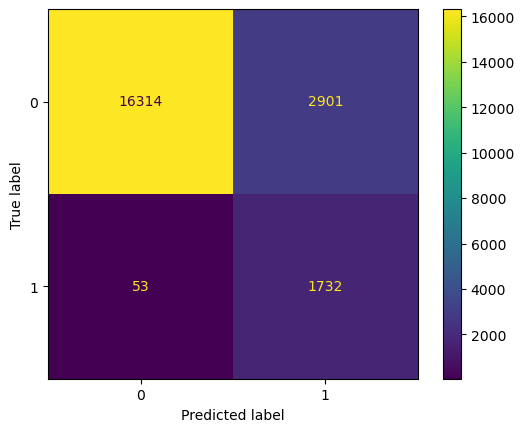

In [75]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,31, 50, 100, 200,300],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    'recall': make_scorer(recall_score),
   'roc_auc': 'roc_auc'
}

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='roc_auc',  
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Best parameters: {'min_samples_leaf': 12, 'max_leaf_nodes': 2, 'max_iter': 500, 'max_features': 0.8, 'max_depth': 11, 'learning_rate': 0.2, 'l2_regularization': 0, 'early_stopping': False, 'class_weight': {0: 1, 1: 20}}

Best model scores:

Model Performance:
Training Recall Score: 0.9702
Test Recall Score: 0.9703
Training F2 Score: 0.7337
Test F2 Score: 0.7356
Training Specificity Score: 0.8475
Test Specificity Score: 0.8490
Training ROC-AUC: 0.9088
Test ROC-AUC: 0.9097
Training PR-AUC: 0.8885
Test PR-AUC: 0.8955
Training Accuracy Score: 0.8579
Test Accuracy Score: 0.8593
Test Confusion Matrix:
 [[16314  2901]
 [   53  1732]]


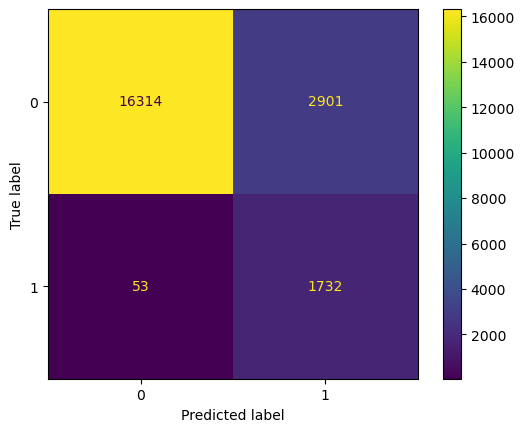

In [76]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,31, 50, 100, 200,300],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    'recall': make_scorer(recall_score),
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score)

}

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='roc_auc', 
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Best parameters: {'min_samples_leaf': 10, 'max_leaf_nodes': 10, 'max_iter': 200, 'max_features': 1.0, 'max_depth': 8, 'learning_rate': 0.1, 'l2_regularization': 0, 'early_stopping': True, 'class_weight': {0: 1, 1: 20}}

Best model scores:

Model Performance:
Training Recall Score: 0.9695
Test Recall Score: 0.9647
Training F2 Score: 0.7464
Test F2 Score: 0.7424
Training Specificity Score: 0.8583
Test Specificity Score: 0.8576
Training ROC-AUC: 0.9139
Test ROC-AUC: 0.9112
Training PR-AUC: 0.8948
Test PR-AUC: 0.8951
Training Accuracy Score: 0.8678
Test Accuracy Score: 0.8667
Test Confusion Matrix:
 [[16479  2736]
 [   63  1722]]


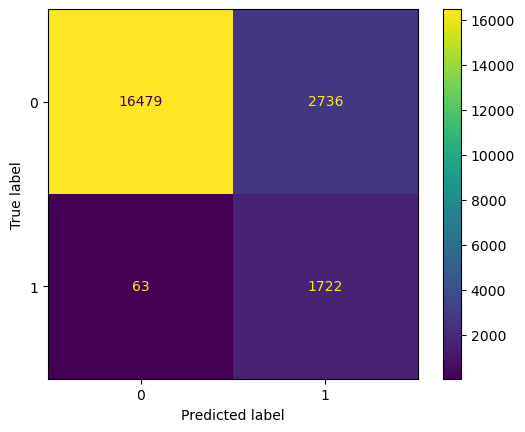

In [77]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 20),
    'max_iter': [50,100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'max_leaf_nodes': [2,10,20,31, 50, 100, 200],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 11.76, 20]] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'roc_auc': 'roc_auc',
    'f3.5_score': make_scorer(fbeta_score, beta=3.5),
    'recall': make_scorer(recall_score),
}

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f3.5_score',  
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

Best parameters: {'min_samples_leaf': 14, 'max_leaf_nodes': 10, 'max_iter': 50, 'max_features': 0.30000000000000004, 'max_depth': 16, 'learning_rate': 0.2, 'l2_regularization': 0.05, 'early_stopping': True, 'class_weight': {0: 1, 1: 17}}

Best model scores:

Model Performance:
Training Recall Score: 0.9611
Test Recall Score: 0.9563
Training F2 Score: 0.7527
Test F2 Score: 0.7483
Training Specificity Score: 0.8678
Test Specificity Score: 0.8668
Training ROC-AUC: 0.9144
Test ROC-AUC: 0.9116
Training PR-AUC: 0.8917
Test PR-AUC: 0.8955
Training Accuracy Score: 0.8757
Test Accuracy Score: 0.8744
Test Confusion Matrix:
 [[16656  2559]
 [   78  1707]]


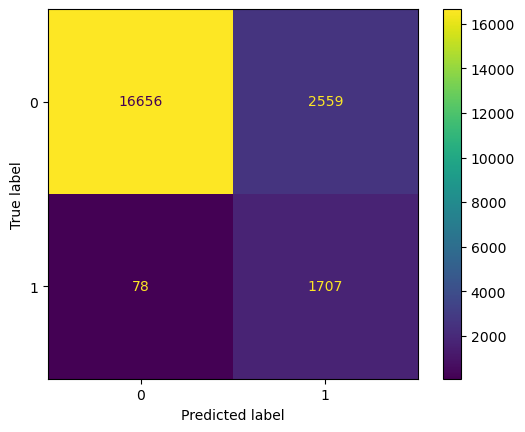

In [78]:
param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 15),
    'max_iter': [50,100, 200, 250, 300, 400],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.05, 0.1, 0.2, 0.5],
    'max_leaf_nodes': [2,10,20,31, 50, 100, 200],
    'class_weight': [{0: 1, 1: w} for w in range(1, 20)] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'roc_auc': 'roc_auc',
    'f3_score': make_scorer(fbeta_score, beta=3.4),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
}

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f3_score', 
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

This one seemed to be the best one from all of above. We adjusted the beta parameter in f beta score to beta=3.2 and also used roc_auc, recall, precision and f1_score as scorers. Refit is done by f_3.2 score.

Best parameters: {'min_samples_leaf': 6, 'max_leaf_nodes': 20, 'max_iter': 250, 'max_features': 0.2, 'max_depth': 18, 'learning_rate': 0.05, 'l2_regularization': 0.2, 'early_stopping': False, 'class_weight': {0: 1, 1: 16}}

Best model scores:

Model Performance:
Training Recall Score: 0.9685
Test Recall Score: 0.9457
Training F2 Score: 0.7806
Test F2 Score: 0.7644
Training Specificity Score: 0.8852
Test Specificity Score: 0.8848
Training ROC-AUC: 0.9269
Test ROC-AUC: 0.9152
Training PR-AUC: 0.9102
Test PR-AUC: 0.8938
Training Accuracy Score: 0.8923
Test Accuracy Score: 0.8900
Test Confusion Matrix:
 [[17001  2214]
 [   97  1688]]


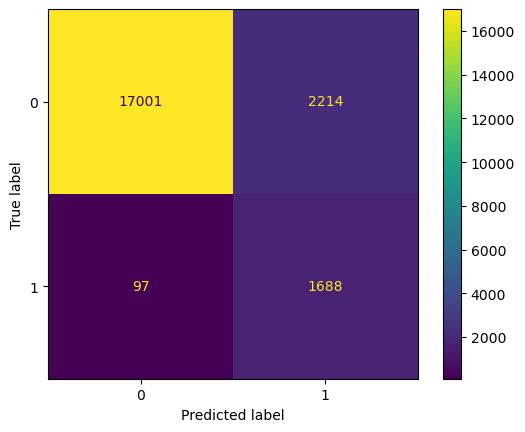

In [79]:

param_dist = {
    'max_depth': range(2, 25),
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1)),
    'min_samples_leaf': range(2, 15),
    'max_iter': [50,100, 200, 250, 300, 400],
    'learning_rate': [0.01, 0.05,0.08, 0.1, 0.2],
    'l2_regularization': [0, 0.05, 0.1, 0.2, 0.5],
    'max_leaf_nodes': [2,10,20,31, 50, 100, 200],
    'class_weight': [{0: 1, 1: w} for w in range(1, 20)] + [None],
    'early_stopping': [False, True]
}

scorers = {
    'roc_auc': 'roc_auc',
    'f3.2_score': make_scorer(fbeta_score, beta=3.2),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
}

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f3.2_score',  
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

gboost3 = random_search_boost.best_estimator_
print("\nBest model scores:")
g3 = scores_model(gboost3)

We tried to tune it even better by doing another randomized search with similar parameters but a bit lower or higher. It didn't satisfy us.

Best parameters: {'min_samples_leaf': 7, 'max_leaf_nodes': 15, 'max_iter': 200, 'max_features': 0.3, 'max_depth': 20, 'learning_rate': 0.05, 'l2_regularization': 0.05, 'early_stopping': True, 'class_weight': {0: 1, 1: 16}}

Best model scores:

Model Performance:
Training Recall Score: 0.9640
Test Recall Score: 0.9518
Training F2 Score: 0.7640
Test F2 Score: 0.7556
Training Specificity Score: 0.8751
Test Specificity Score: 0.8749
Training ROC-AUC: 0.9195
Test ROC-AUC: 0.9134
Training PR-AUC: 0.8991
Test PR-AUC: 0.8943
Training Accuracy Score: 0.8826
Test Accuracy Score: 0.8815
Test Confusion Matrix:
 [[16812  2403]
 [   86  1699]]


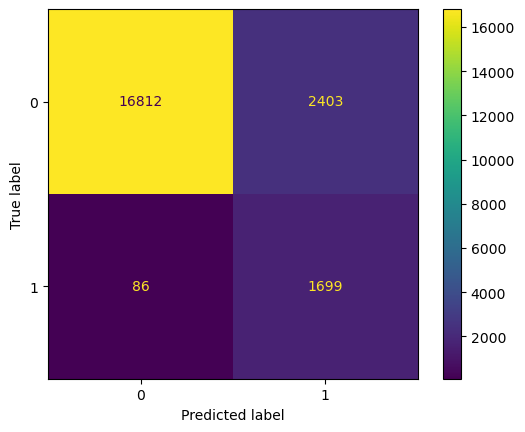

In [80]:
param_dist = {
    'max_depth': [16, 18, 20],
    'max_features': [0.1, 0.2, 0.3],
    'min_samples_leaf': [5, 6, 7],
    'max_iter': [200, 250, 300],
    'learning_rate': [0.03, 0.05, 0.07,0.1,0.2],
    'l2_regularization': [0.05,0.1, 0.2, 0.3],
    'max_leaf_nodes': [15, 20, 25],
    'class_weight': [{0: 1, 1: w} for w in [14, 15,16, 18]],
    'early_stopping': [False,True]
}

scorers = {
    'roc_auc': 'roc_auc',
    'f3_score': make_scorer(fbeta_score, beta=3.2),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
}

random_search_boost = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=scorers,
    refit='f3_score',  
    random_state=32,
    n_jobs=-1,
    verbose=0
)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_
print("\nBest model scores:")
metrics = scores_model(boost_best)

We tried inventing some new modeles using the chosen parameters to tune it manually.


Model Performance:
Training Recall Score: 0.6999
Test Recall Score: 0.7087
Training F2 Score: 0.7435
Test F2 Score: 0.7492
Training Specificity Score: 0.9994
Test Specificity Score: 0.9981
Training ROC-AUC: 0.8496
Test ROC-AUC: 0.8534
Training PR-AUC: 0.9206
Test PR-AUC: 0.8920
Training Accuracy Score: 0.9739
Test Accuracy Score: 0.9735
Test Confusion Matrix:
 [[19178    37]
 [  520  1265]]


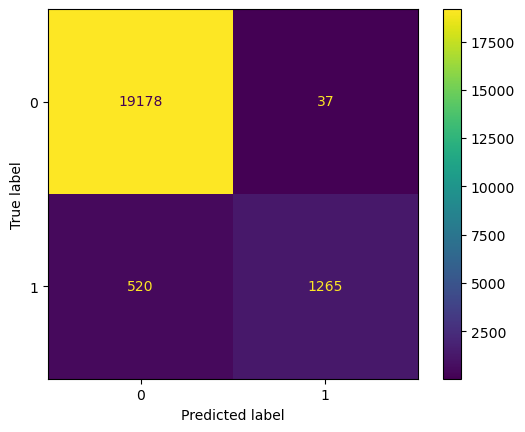

In [81]:
gboost1 = HistGradientBoostingClassifier(
    learning_rate=0.1,
    class_weight={0: 1, 1: 11.76},
    max_depth=15,
    early_stopping=True,
    min_samples_leaf=7,
    max_leaf_nodes=10,
    max_iter=200,
    random_state=32
)
g1 = scores_model(gboost)


Model Performance:
Training Recall Score: 0.9505
Test Recall Score: 0.9423
Training F2 Score: 0.7718
Test F2 Score: 0.7658
Training Specificity Score: 0.8879
Test Specificity Score: 0.8876
Training ROC-AUC: 0.9192
Test ROC-AUC: 0.9149
Training PR-AUC: 0.8973
Test PR-AUC: 0.8952
Training Accuracy Score: 0.8932
Test Accuracy Score: 0.8922
Test Confusion Matrix:
 [[17055  2160]
 [  103  1682]]


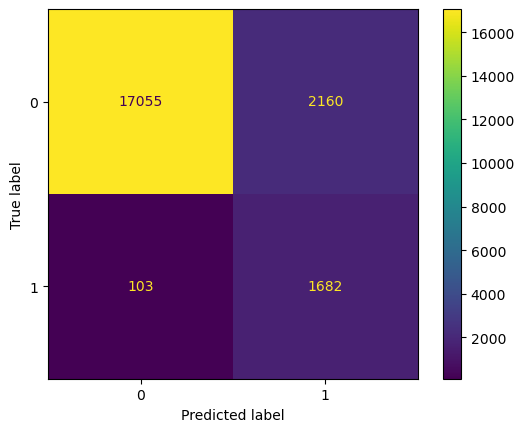

In [82]:
gboost = HistGradientBoostingClassifier(
    learning_rate=0.2,
    class_weight={0: 1, 1: 13},
    max_depth=20,
    early_stopping=True,
    min_samples_leaf=7,
    max_leaf_nodes=10,
    max_iter=300,
    random_state=32,
    l2_regularization=0.1
)
_ = scores_model(gboost)


Model Performance:
Training Recall Score: 0.9517
Test Recall Score: 0.9423
Training F2 Score: 0.7744
Test F2 Score: 0.7666
Training Specificity Score: 0.8891
Test Specificity Score: 0.8882
Training ROC-AUC: 0.9204
Test ROC-AUC: 0.9153
Training PR-AUC: 0.8980
Test PR-AUC: 0.8961
Training Accuracy Score: 0.8944
Test Accuracy Score: 0.8928
Test Confusion Matrix:
 [[17067  2148]
 [  103  1682]]


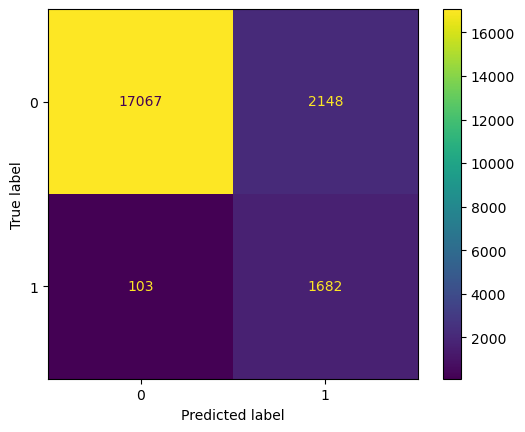

In [83]:
gboost = HistGradientBoostingClassifier(
    learning_rate=0.2,
    class_weight={0: 1, 1: 13},
    max_depth=20,
    early_stopping=True,
    min_samples_leaf=6,
    max_leaf_nodes=10,
    max_iter=500,
    random_state=32,
    l2_regularization=0.1
)
g4 = scores_model(gboost)

We wanted to see if a different threshold would make a difference - the best one turned out to be 0.53.

The best threshold: 0.53, F2: 0.8580

Model Performance:
Training Recall Score: 0.9462
Test Recall Score: 0.9389
Training F2 Score: 0.7797
Test F2 Score: 0.7746
Training Specificity Score: 0.8958
Test Specificity Score: 0.8958
Training ROC-AUC: 0.9210
Test ROC-AUC: 0.9174
Training PR-AUC: 0.8980
Test PR-AUC: 0.8961
Training Accuracy Score: 0.9001
Test Accuracy Score: 0.8995
Test Confusion Matrix:
 [[17213  2002]
 [  109  1676]]


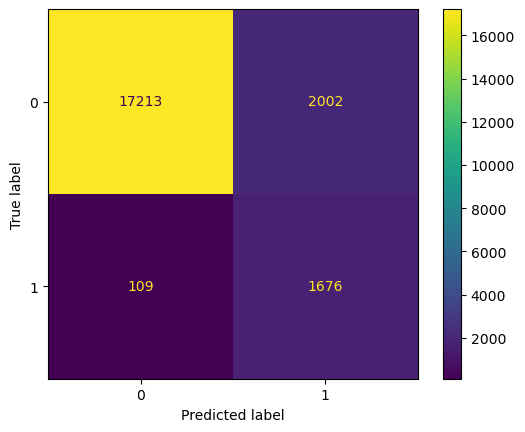

(0.9210293953647032,
 0.9173730694463578,
 0.8979856138312493,
 0.8961292131513019,
 0.946218487394958,
 0.9389355742296919,
 0.7797475367021487,
 0.7746348678129045,
 0.9001224489795918,
 0.8994761904761904,
 0.8958403033344485,
 0.8958105646630237)

In [84]:
y_test_scores = pipeline.predict_proba(X_test)[:, 1]

best_thresh = 0.5
best_f2 = 0
for t in np.arange(0.1, 0.91, 0.01):
    preds = (y_test_scores >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=3.2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

print(f"The best threshold: {best_thresh:.2f}, F2: {best_f2:.4f}")
scores_model(gboost, threshold=best_thresh)


Selecting k-best features didn't help - all of the features were relevant.

Najlepsza liczba cech: 23

Model Performance:
Training Recall Score: 0.9462
Test Recall Score: 0.9389
Training F2 Score: 0.7797
Test F2 Score: 0.7746
Training Specificity Score: 0.8958
Test Specificity Score: 0.8958
Training ROC-AUC: 0.9210
Test ROC-AUC: 0.9174
Training PR-AUC: 0.8980
Test PR-AUC: 0.8961
Training Accuracy Score: 0.9001
Test Accuracy Score: 0.8995
Test Confusion Matrix:
 [[17213  2002]
 [  109  1676]]


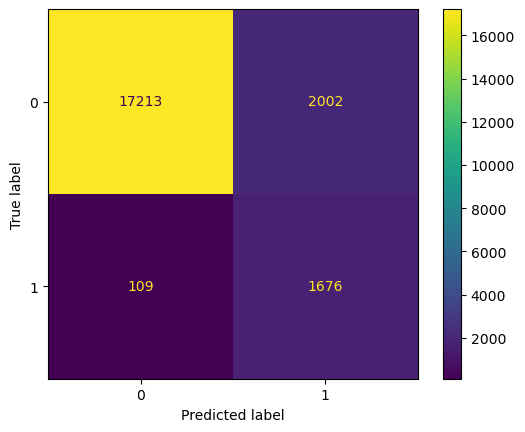

In [85]:
pipe = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif)),
    ('model', gboost)
])

param_grid = {
    'select__k': [10, 13,15,20, 23]
}

grid = GridSearchCV(
    pipe, 
    param_grid, 
    scoring=make_scorer(fbeta_score, beta=3.2), 
    cv=5, 
    n_jobs=-1,
    verbose=0
)
pipeline_fit(grid)
best_k = grid.best_params_['select__k']
print(f"Najlepsza liczba cech: {best_k}")
_ = scores_model(grid.best_estimator_, threshold=best_thresh)

Voting gave no better results.


Model Performance:
Training Recall Score: 0.9496
Test Recall Score: 0.9513
Training F2 Score: 0.7411
Test F2 Score: 0.7402
Training Specificity Score: 0.8646
Test Specificity Score: 0.8630
Training ROC-AUC: 0.9071
Test ROC-AUC: 0.9071
Training PR-AUC: 0.8825
Test PR-AUC: 0.8872
Training Accuracy Score: 0.8719
Test Accuracy Score: 0.8705
Test Confusion Matrix:
 [[16583  2632]
 [   87  1698]]


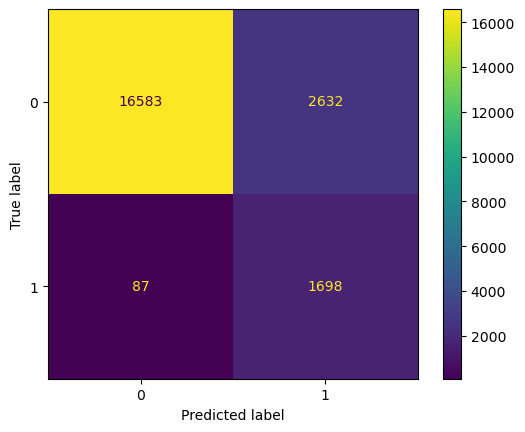

In [86]:
rf = RandomForestClassifier(
    n_estimators=52,
    min_samples_split=10,
    max_features=7,
    max_depth=6,
    class_weight={0: 1, 1: 13},
    random_state=32,
    n_jobs=-1
)

gboost = HistGradientBoostingClassifier(
    learning_rate=0.2,
    class_weight={0: 1, 1: 13},
    max_depth=20,
    early_stopping=True,
    min_samples_leaf=6,
    max_leaf_nodes=10,
    max_iter=500,
    random_state=32,
    l2_regularization=0.1
)

logreg = LogisticRegression(
    class_weight={0: 1, 1: 13},
    max_iter=1000,
    solver='liblinear',
    random_state=32
)

voting_clf = VotingClassifier(
    estimators=[
        ('gboost', gboost),
        ('rf', rf),
        ('logreg', logreg)
    ],
    voting='soft',
    weights=[1,3, 1],
    n_jobs=-1
)

pipeline_fit(voting_clf)
_ = scores_model(voting_clf)

A barplot summarising our best models.

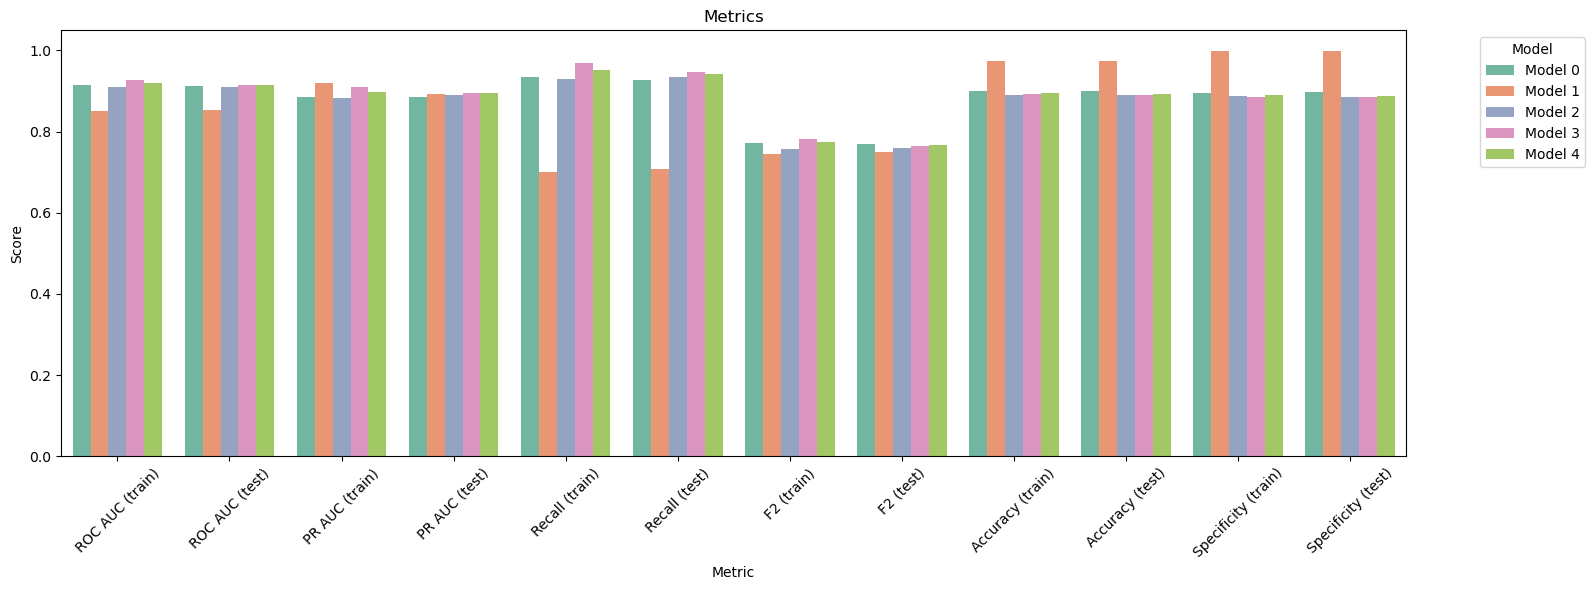

In [87]:
metrics = [
    'ROC AUC (train)', 'ROC AUC (test)',
    'PR AUC (train)', 'PR AUC (test)',
    'Recall (train)', 'Recall (test)',
    'F2 (train)', 'F2 (test)',
    'Accuracy (train)', 'Accuracy (test)',
    'Specificity (train)', 'Specificity (test)'
]

all_results = [g0, g1, g2, g3, g4]

df = pd.DataFrame(all_results, columns=metrics, index=[f'Model {i}' for i in range(len(all_results))])

df_long = df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
df_long.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(16, 6))
sns.barplot(data=df_long, x='Metric', y='Value', hue='Model', palette='Set2')
plt.title('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

We chose model number 3, so this one

In [88]:
gboost3 = HistGradientBoostingClassifier(
    random_state=32,  
    min_samples_leaf=6,  
    max_leaf_nodes=20,  
    max_iter=250,  
    max_features=0.2,  
    max_depth=18,  
    learning_rate=0.05,  
    l2_regularization=0.2,  
    early_stopping=False,  
    class_weight={0: 1, 1: 16}  
)

**SHAP**

To make our model interpretable we used SHAP.

In [89]:
X_transformed_train = pipeline[:-1].transform(X_train)
X_transformed_train = X_transformed_train.astype(float)
X_transformed_test = pipeline[:-1].transform(X_test)
X_transformed_test = X_transformed_test.astype(float)

SHAP for training data

In [90]:
model = gboost3
pipeline_fit(model)  

explainer = shap.Explainer(model.predict_proba, X_transformed_train)
shap_values = explainer(X_transformed_train)

PermutationExplainer explainer: 49001it [2:43:14,  5.00it/s]                             


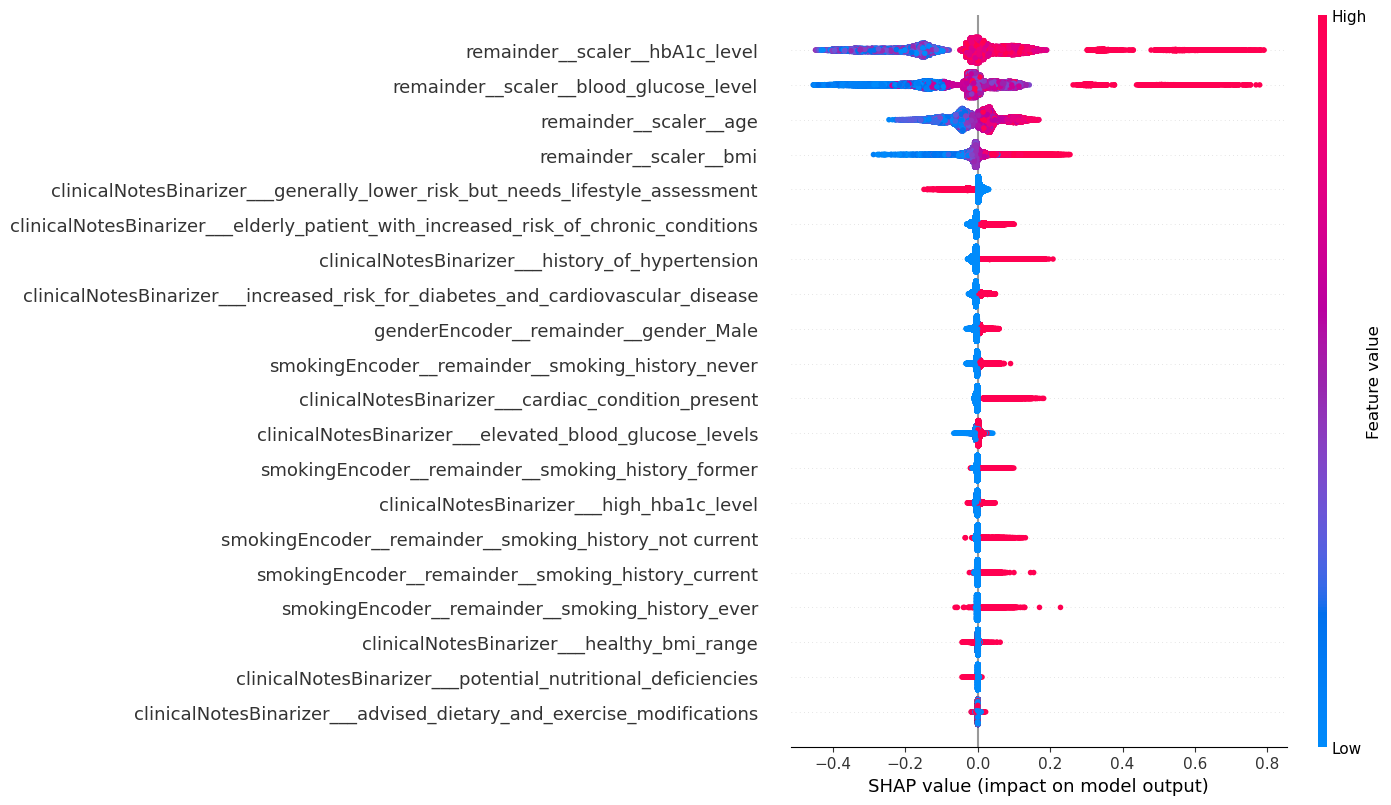

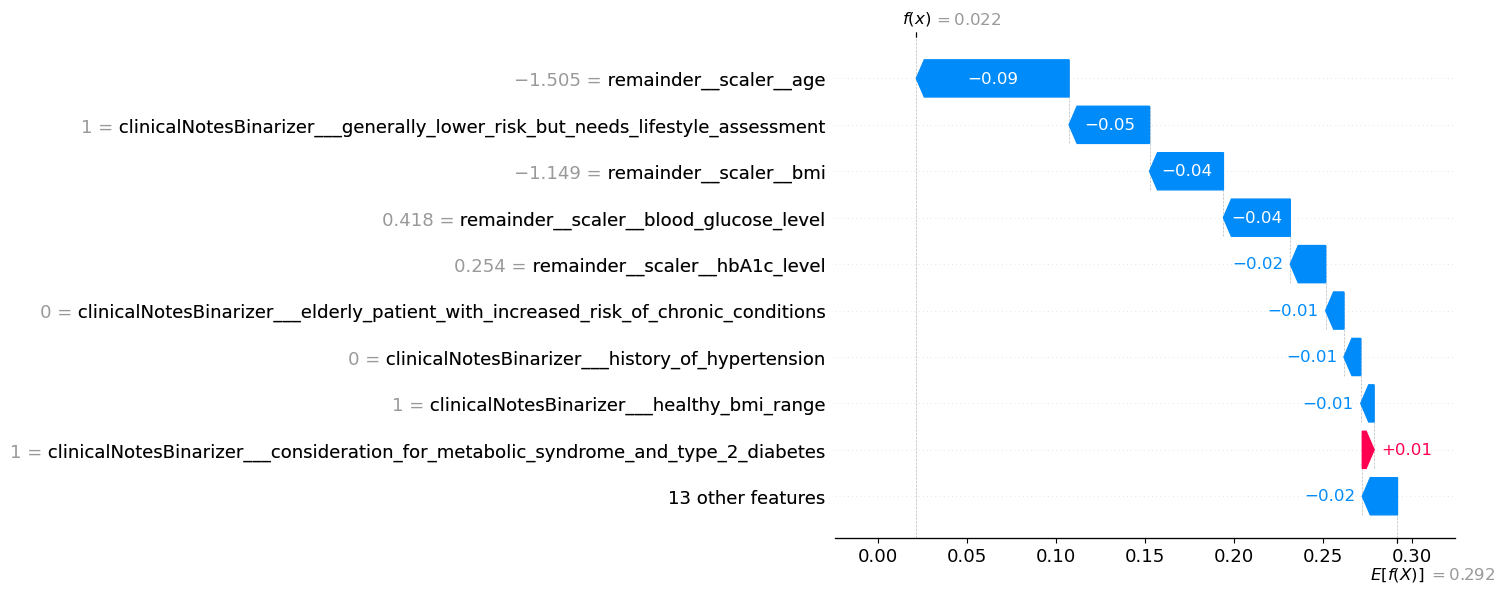

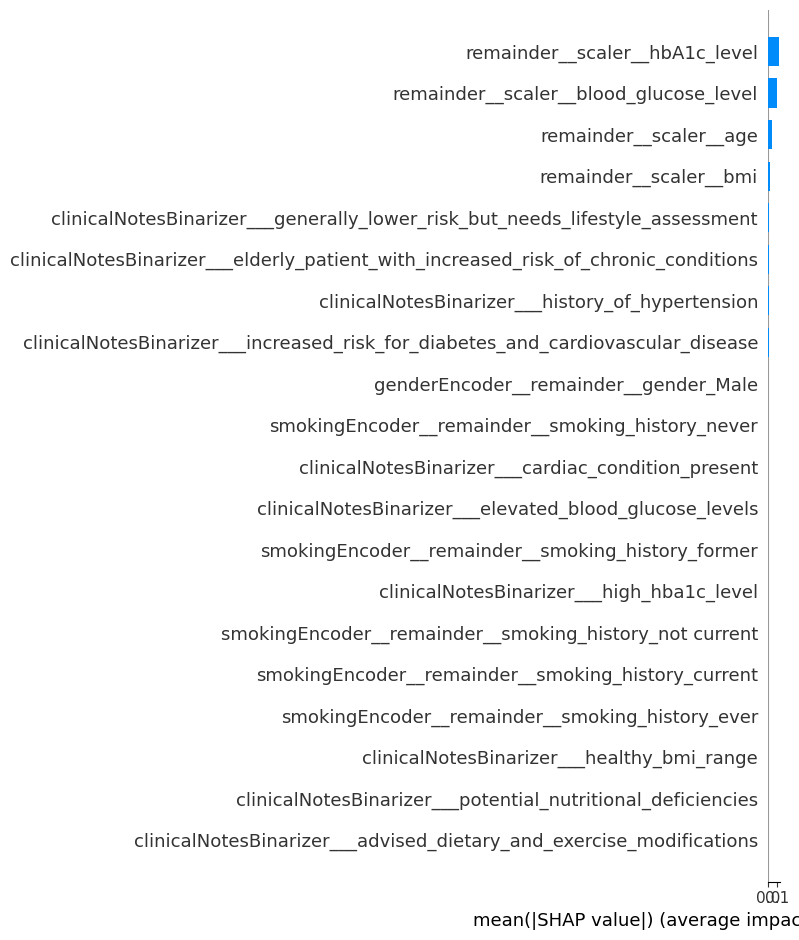

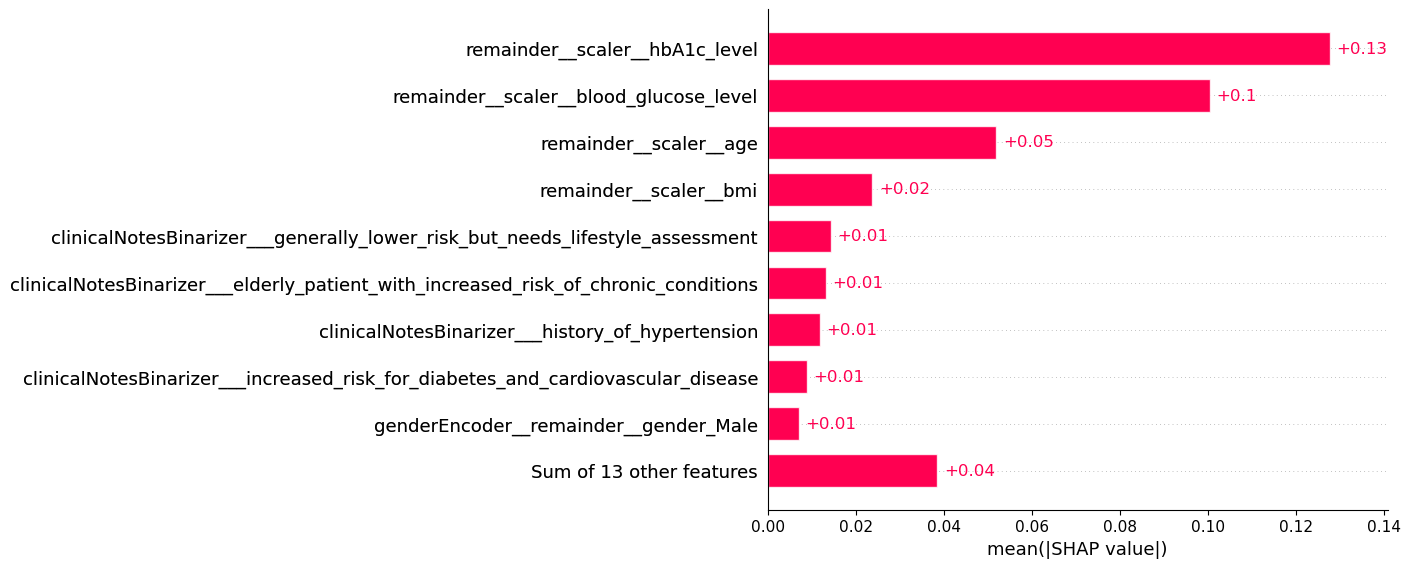

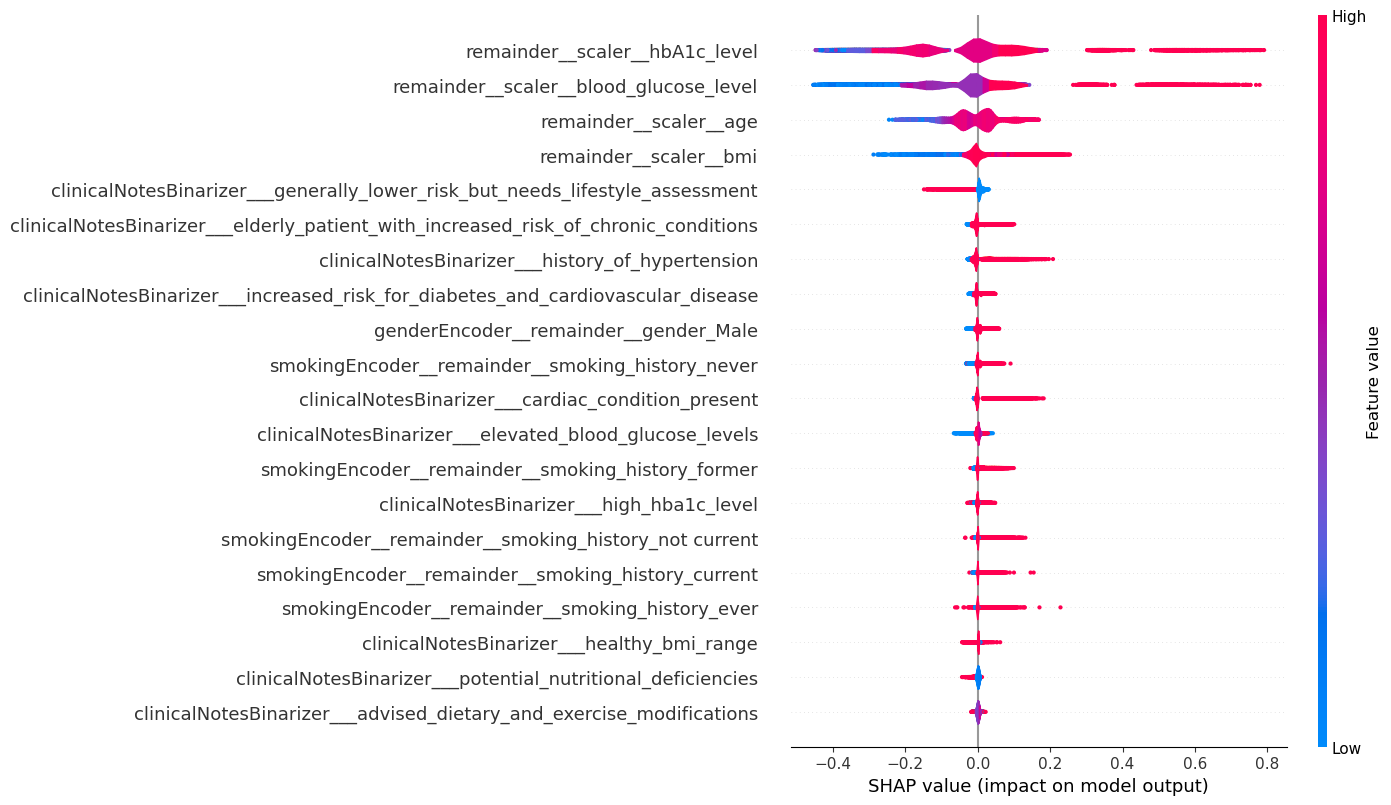

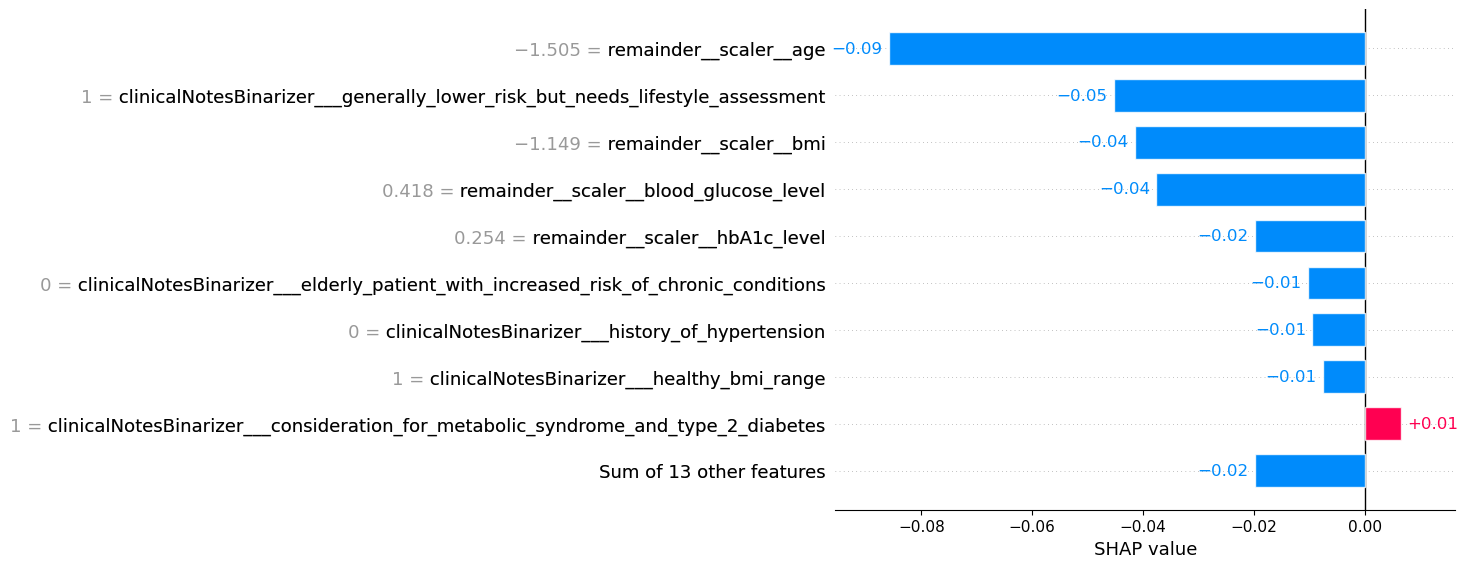

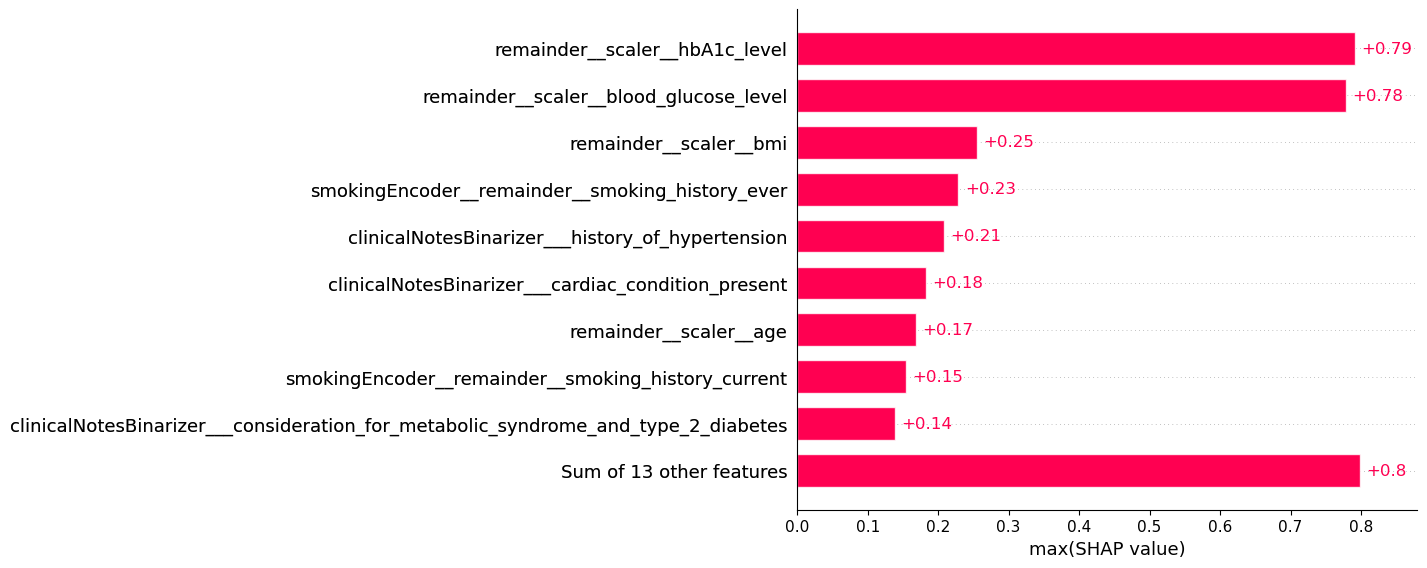

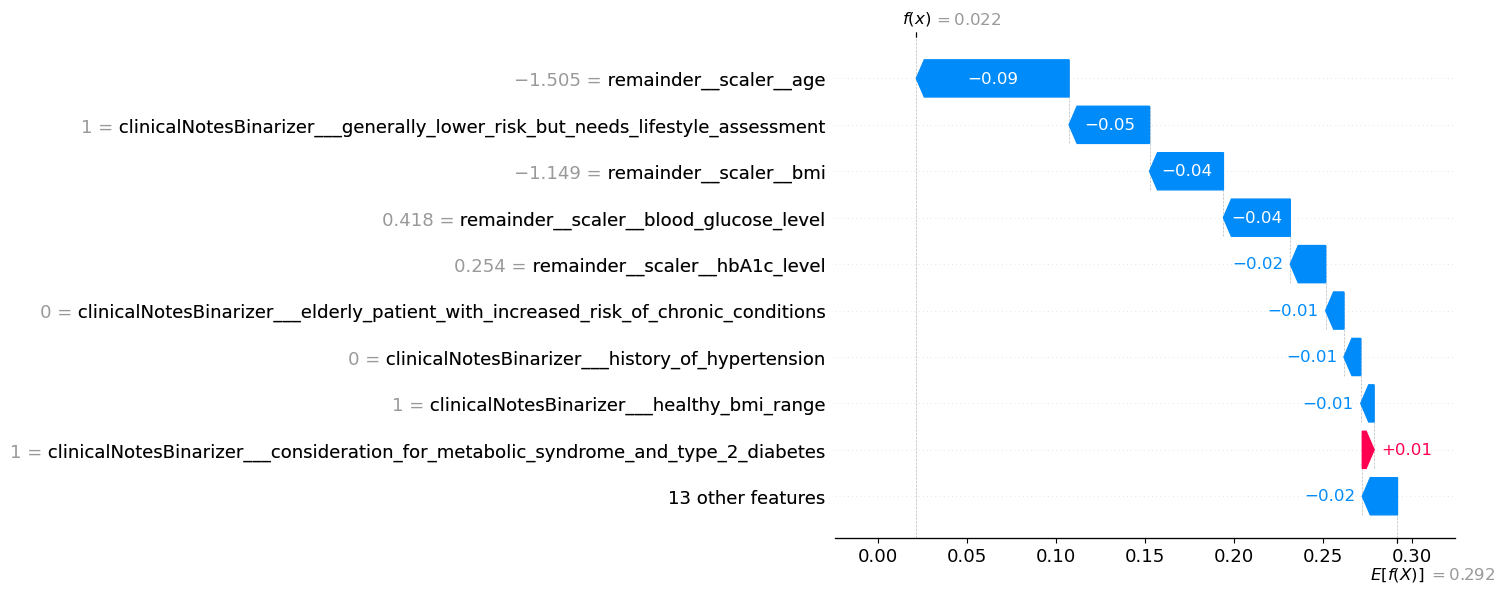

In [101]:
feature_names = X_transformed_train.columns.tolist()
shap.summary_plot(shap_values[:, :, 1], X_transformed_train, feature_names=feature_names, show=True)
shap.plots.waterfall(shap_values[0, :, 1])
shap.summary_plot(shap_values[:, :, 1], X_transformed_train, feature_names=feature_names, plot_type="bar", show=True)
shap.plots.bar(shap_values[:, :, 1])
shap.summary_plot(shap_values[:, :, 1], X_transformed_train, feature_names=feature_names, plot_type="violin", show=True)
shap.plots.bar(shap_values[0, :, 1])
shap.plots.bar(shap_values[:, :, 1].max(axis=0))
shap.plots.waterfall(shap_values[0, :, 1])
#shap.plots.force(shap_values[0, :, 1], feature_names=feature_names)
#shap.plots.force(shap_values[0, :, 1], feature_names=feature_names)
#shap.plots.heatmap(shap_values[:, :, 1])

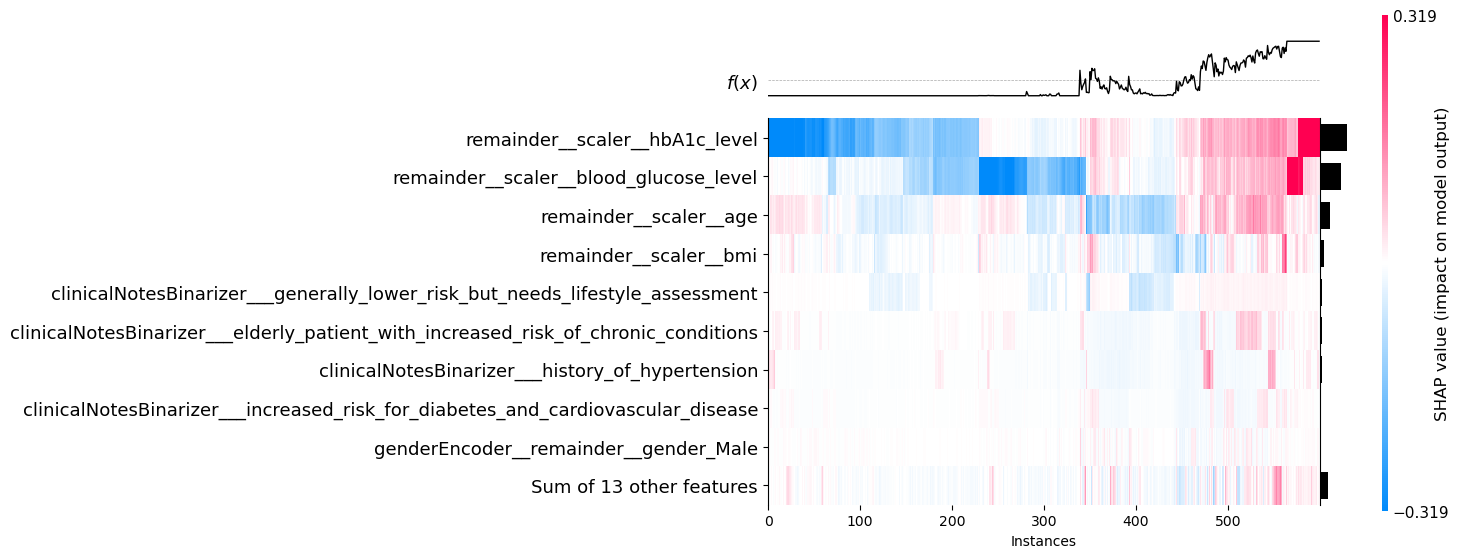

<Axes: xlabel='Instances'>

In [106]:
idx = np.random.choice(shap_values.shape[0], 600, replace=False)
shap.plots.heatmap(shap_values[idx, :, 1])

SHAP for test data

In [108]:
model = gboost3
pipeline_fit(model)  

explainer = shap.Explainer(model.predict_proba, X_transformed_test)
shap_values = explainer(X_transformed_test)

PermutationExplainer explainer: 21001it [1:08:03,  5.13it/s]                           


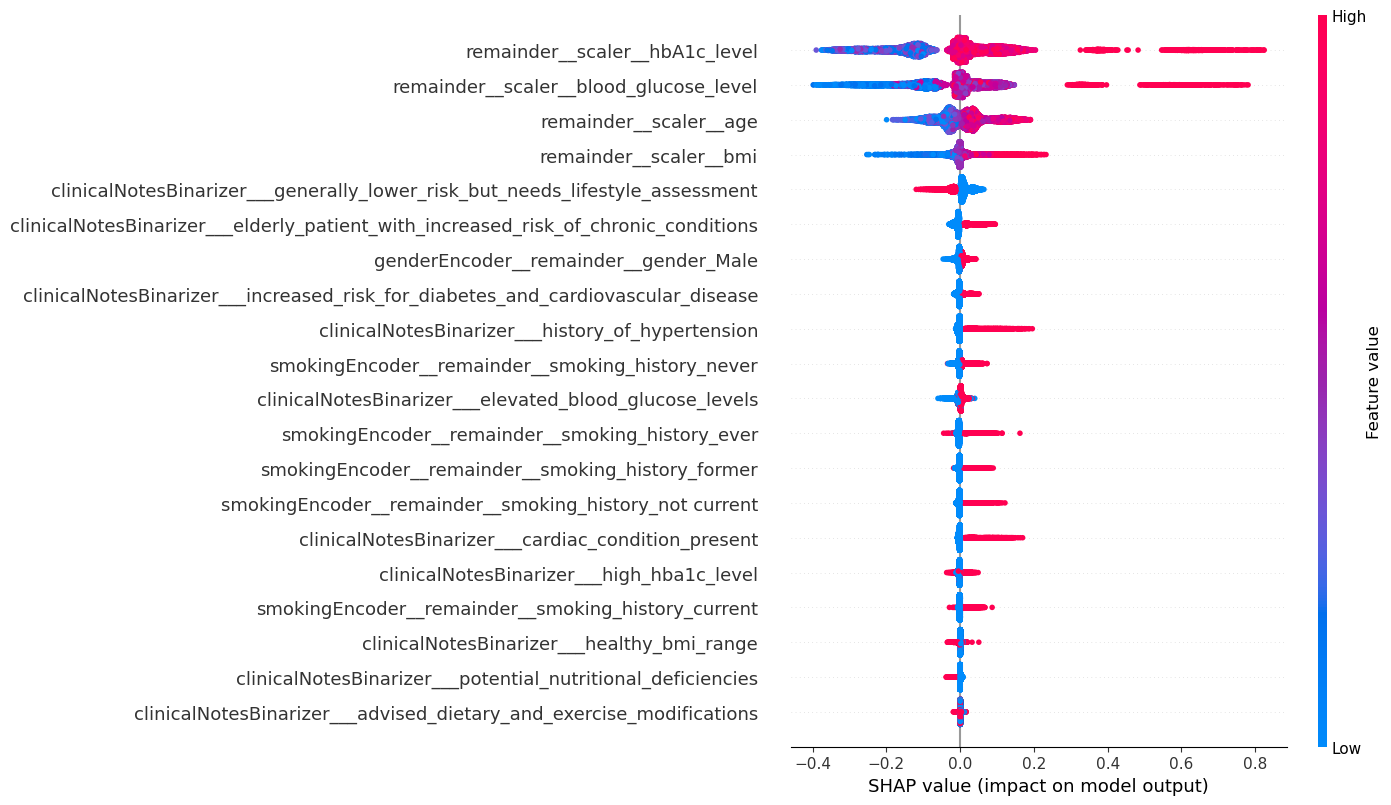

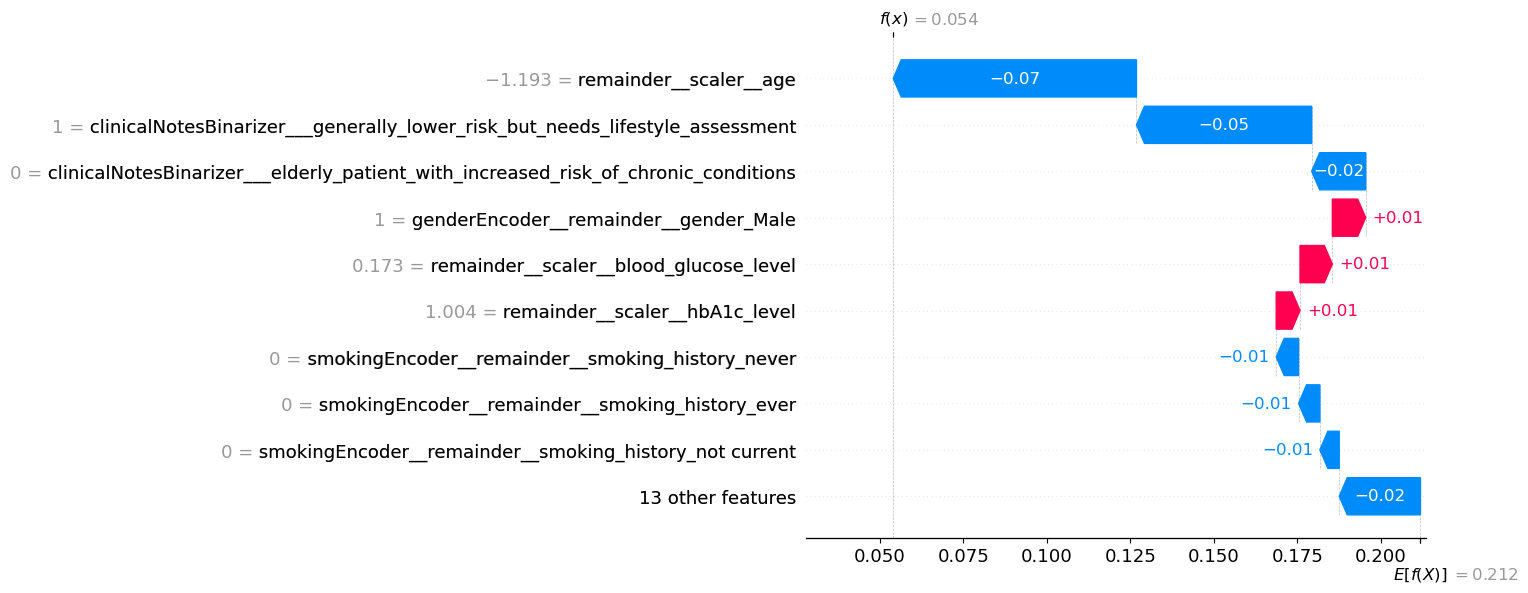

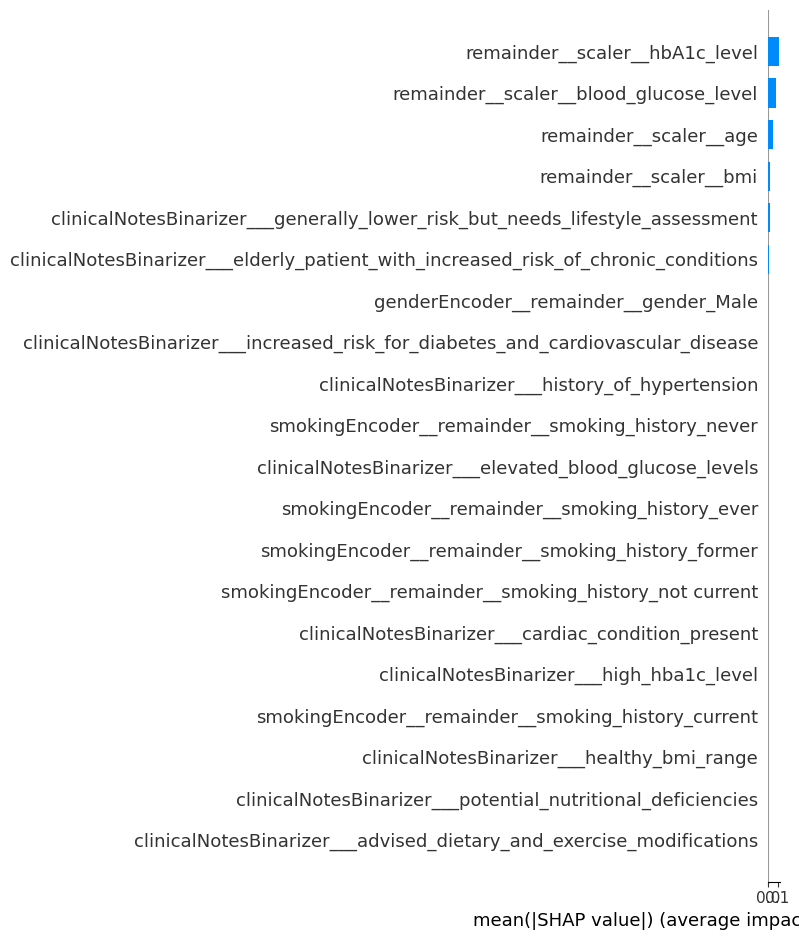

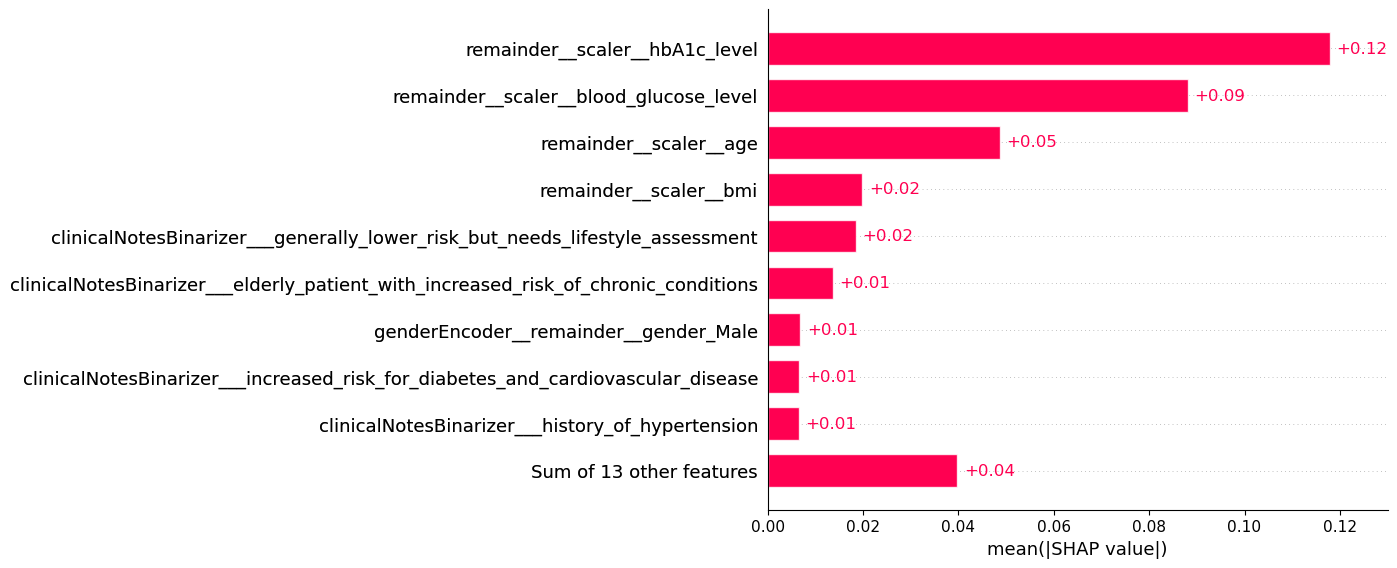

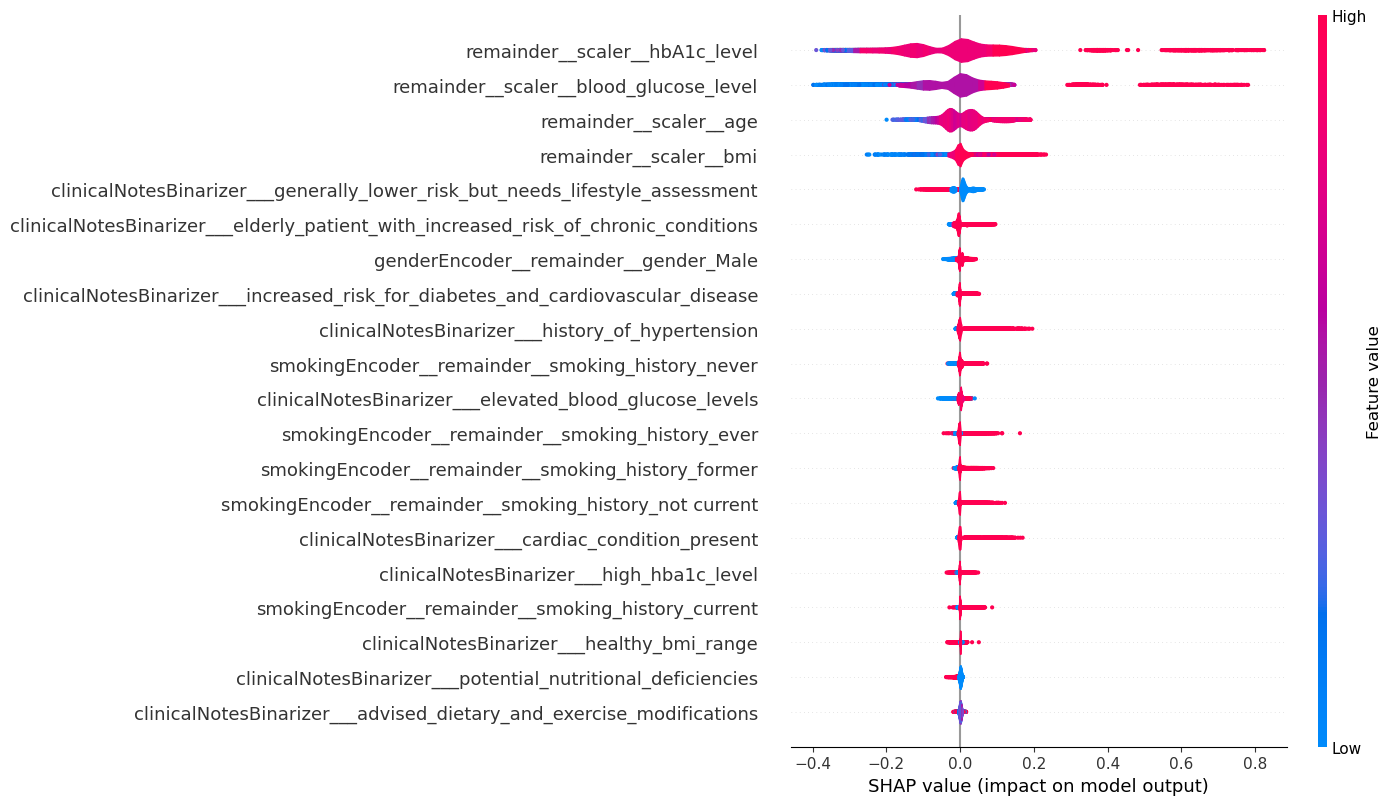

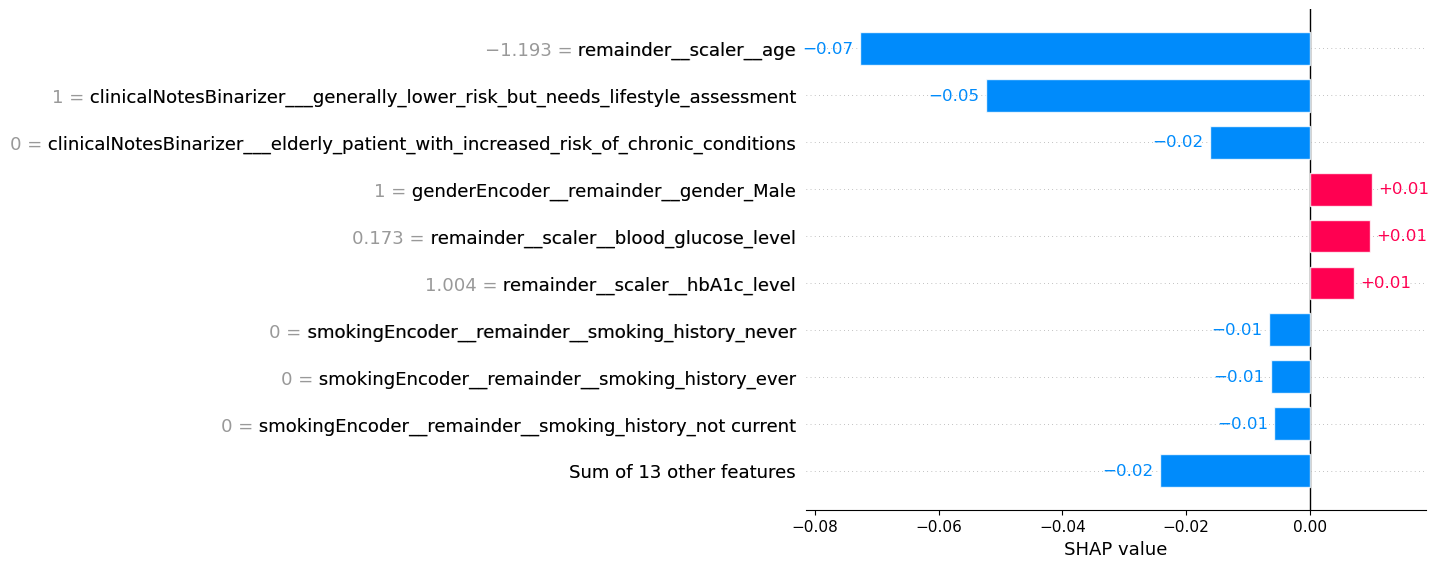

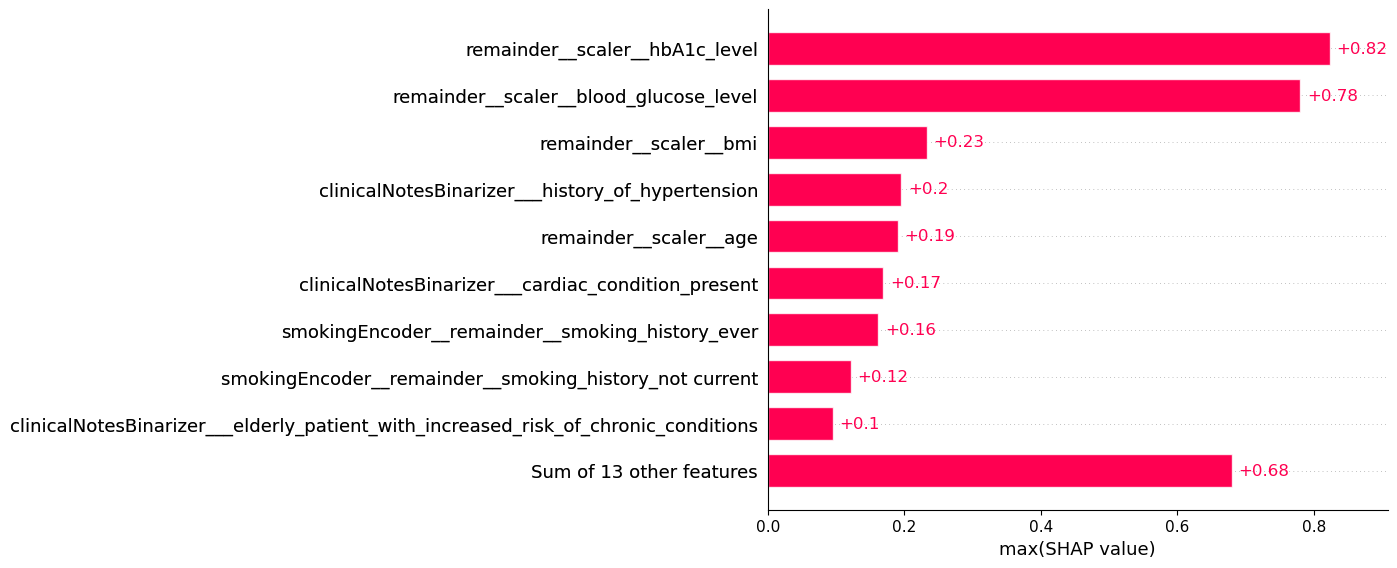

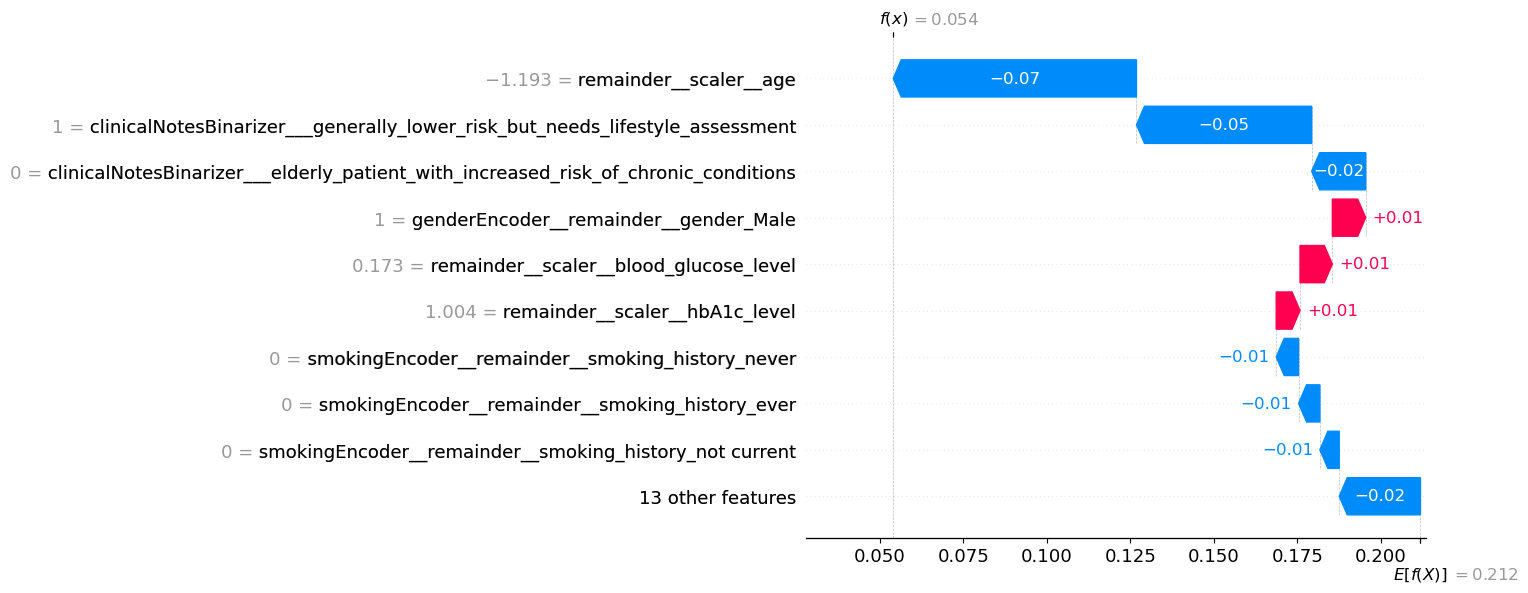

In [109]:
feature_names = X_transformed_test.columns.tolist()
shap.summary_plot(shap_values[:, :, 1], X_transformed_test, feature_names=feature_names, show=True)
shap.plots.waterfall(shap_values[0, :, 1])
shap.summary_plot(shap_values[:, :, 1], X_transformed_test, feature_names=feature_names, plot_type="bar", show=True)
shap.plots.bar(shap_values[:, :, 1])
shap.summary_plot(shap_values[:, :, 1], X_transformed_test, feature_names=feature_names, plot_type="violin", show=True)
shap.plots.bar(shap_values[0, :, 1])
shap.plots.bar(shap_values[:, :, 1].max(axis=0))
shap.plots.waterfall(shap_values[0, :, 1])

**Some conclusions from SHAP**

- The features with the greatest impact on our model are: age, BMI, the "lower risk but needs lifestyle assessment" note, glucose level, and HbA1c level.
- Overall, individual features do not seem to have a large impact, but even the less important ones collectively contribute significant SHAP values.
- For HbA1c level, glucose level, age, and BMI, the same pattern applies: higher values have a stronger positive impact on predicting diabetes, while lower values contribute negatively to the prediction.
- For most binary features, a value of 0 tends to have little or no impact on the model's output, whereas a value of 1 usually has a positive influence.

We compared metrics for our final model

In [93]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=1, random_state=32)
    
    recall_scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')
    f2_scores = cross_val_score(model, X, y, scoring=make_scorer(fbeta_score, beta=2), cv=cv, n_jobs=-1, error_score='raise')
    roc_auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    
    return recall_scores, f2_scores, roc_auc_scores

In [94]:
scores_train = evaluate_model(gboost3, X_transformed_train, y_train)
scores_test = evaluate_model(gboost3, X_transformed_test, y_test)

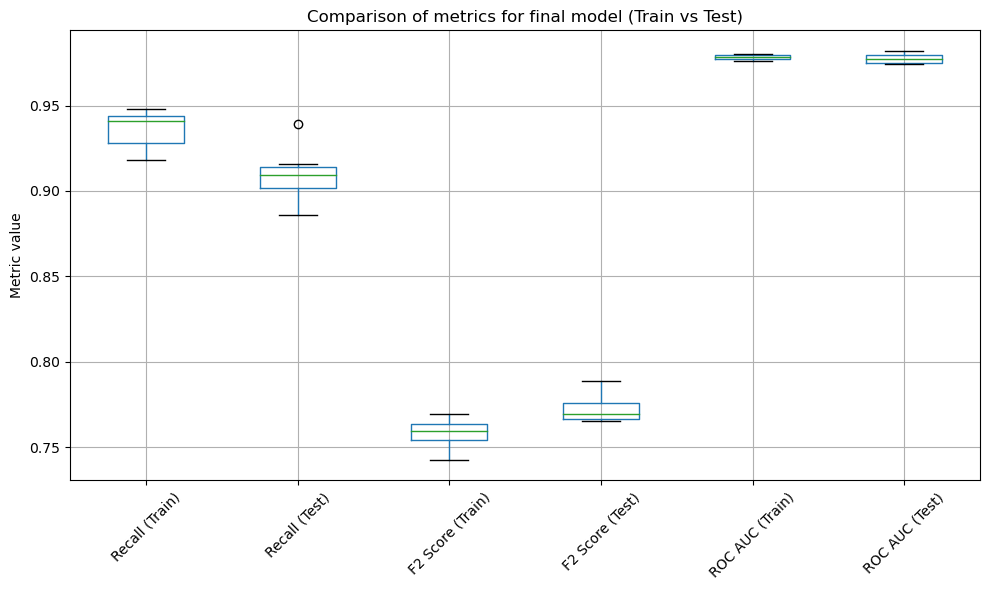

In [95]:
recall_train, f2_train, roc_auc_train = scores_train
recall_test, f2_test, roc_auc_test = scores_test

df = pd.DataFrame({
    'Recall (Train)': recall_train,
    'Recall (Test)': recall_test,
    'F2 Score (Train)': f2_train,
    'F2 Score (Test)': f2_test,
    'ROC AUC (Train)': roc_auc_train,
    'ROC AUC (Test)': roc_auc_test,
})

plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Comparison of metrics for final model (Train vs Test)')
plt.ylabel('Metric value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

ROC-AUC curve

In [96]:
def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    pipeline_fit(model)
    
    y_train_scores = pipeline.predict_proba(X_train)[:, 1]
    y_test_scores = pipeline.predict_proba(X_test)[:, 1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label='Train ROC Curve', color='blue')
    plt.plot(fpr_test, tpr_test, label='Test ROC Curve', color='green')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

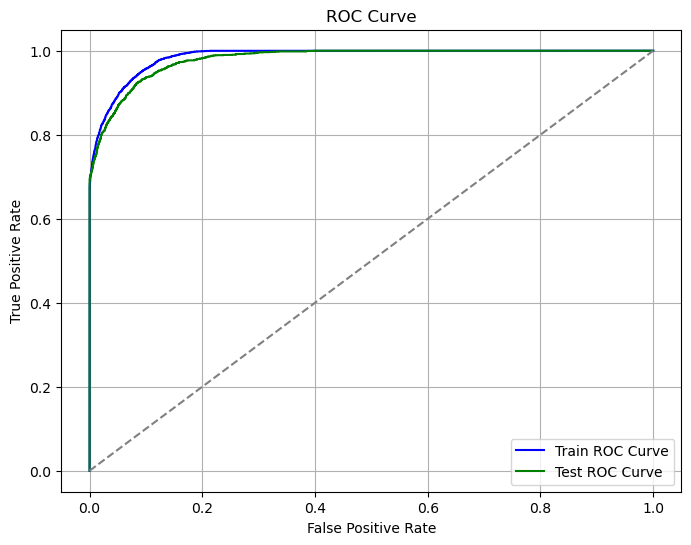

In [97]:
plot_roc_curve(gboost3, X_train, y_train, X_test, y_test)

Final pipeline and results

In [98]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95)),
    ('model', gboost3)
])

In [99]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clip_bmi',
                 FunctionTransformer(func=<function clip_bmi at 0x0000015F4427FEC0>)),
                ('preprocessor1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['year', 'location',
                                                   'race:AfricanAmerican',
                                                   'race:Asian',
                                                   'race:Caucasian',
                                                   'race:Hispanic',
                                                   'race:Other']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'bmi', 'hbA1c_level',
                                                   'blood_gluc...
                                                  ['remainder__clinical_notes'])])),
                ('to_df2',
                 FunctionTransformer(func=<function <lambda> at 0x0000015F4BD77880>)),
                ('remove_high_corr', HighCorrelationRemover()),
                ('model',
                 HistGradientBoostingClassifier(class_weight={0: 1, 1: 16},
                                                early_stopping=False,
                                                l2_regularization=0.2,
                                                learning_rate=0.05,
                                                max_depth=18, max_features=0.2,
                                                max_iter=250, max_leaf_nodes=20,
                                                min_samples_leaf=6,
                                                random_state=32))])


Model Performance:
Training Recall Score: 0.9685
Test Recall Score: 0.9457
Training F2 Score: 0.7806
Test F2 Score: 0.7644
Training Specificity Score: 0.8852
Test Specificity Score: 0.8848
Training ROC-AUC: 0.9269
Test ROC-AUC: 0.9152
Training PR-AUC: 0.9102
Test PR-AUC: 0.8938
Training Accuracy Score: 0.8923
Test Accuracy Score: 0.8900
Test Confusion Matrix:
 [[17001  2214]
 [   97  1688]]


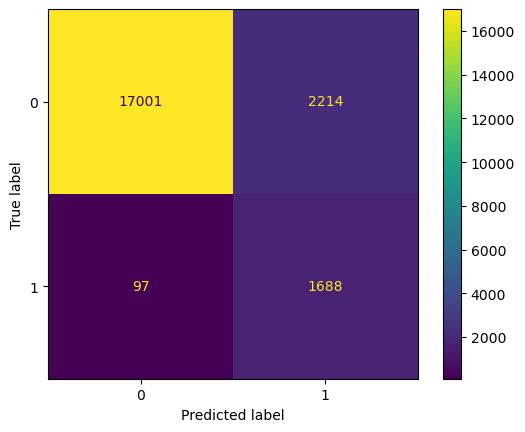

In [100]:
_ = scores_model(gboost3)

The validation team didn't report any errors.